# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]


X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [24]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-8, 1e-7, 1e-6]
regularization_strengths = [5e4, 5e5, 5e6,.01,.05,.1,.2,.5]
# num_color_bins = [10, 20, 5, 40]
results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,\
                              num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        accuracy_training = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        accuracy_val = np.mean(y_val == y_val_pred)
        results[(lr,reg)] = accuracy_training, accuracy_val
        if accuracy_val > best_val:
            best_val = accuracy_val
            best_svm = svm


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 90.498613
iteration 100 / 1500: loss 82.742788
iteration 200 / 1500: loss 75.729859
iteration 300 / 1500: loss 69.376622
iteration 400 / 1500: loss 63.615689
iteration 500 / 1500: loss 58.430328
iteration 600 / 1500: loss 53.710520
iteration 700 / 1500: loss 49.470186
iteration 800 / 1500: loss 45.610851
iteration 900 / 1500: loss 42.130394
iteration 1000 / 1500: loss 38.974927
iteration 1100 / 1500: loss 36.111034
iteration 1200 / 1500: loss 33.540967
iteration 1300 / 1500: loss 31.203057
iteration 1400 / 1500: loss 29.091839
iteration 0 / 1500: loss 818.988471
iteration 100 / 1500: loss 306.245161
iteration 200 / 1500: loss 118.072865
iteration 300 / 1500: loss 49.028872
iteration 400 / 1500: loss 23.689866
iteration 500 / 1500: loss 14.391560
iteration 600 / 1500: loss 10.978275
iteration 700 / 1500: loss 9.726476
iteration 800 / 1500: loss 9.266568
iteration 900 / 1500: loss 9.097709
iteration 1000 / 1500: loss 9.035902
iteration 1100 / 1500: loss 9.013218


iteration 600 / 1500: loss 8.993124
iteration 700 / 1500: loss 8.979372
iteration 800 / 1500: loss 8.975309
iteration 900 / 1500: loss 9.006436
iteration 1000 / 1500: loss 8.980765
iteration 1100 / 1500: loss 8.979757
iteration 1200 / 1500: loss 8.990049
iteration 1300 / 1500: loss 8.998368
iteration 1400 / 1500: loss 8.981438
iteration 0 / 1500: loss 97.097969
iteration 100 / 1500: loss 9.003110
iteration 200 / 1500: loss 8.999933
iteration 300 / 1500: loss 8.999958
iteration 400 / 1500: loss 8.999921
iteration 500 / 1500: loss 8.999957
iteration 600 / 1500: loss 9.000136
iteration 700 / 1500: loss 9.000199
iteration 800 / 1500: loss 9.000085
iteration 900 / 1500: loss 9.000068
iteration 1000 / 1500: loss 8.999948
iteration 1100 / 1500: loss 9.000026
iteration 1200 / 1500: loss 9.000007
iteration 1300 / 1500: loss 9.000157
iteration 1400 / 1500: loss 9.000018
iteration 0 / 1500: loss 857.840640
iteration 100 / 1500: loss 9.000061
iteration 200 / 1500: loss 9.000069
iteration 300 / 150

/Users/hamzaliaqet/Downloads/code/cs233n/assignment1/cs231n/classifiers/linear_svm.py:107: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/hamzaliaqet/Downloads/code/cs233n/assignment1/cs231n/classifiers/linear_svm.py:107: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/Users/hamzaliaqet/Downloads/code/cs233n/assignment1/cs231n/classifiers/linear_svm.py:130: RuntimeWarning: overflow encountered in multiply
  dW += reg * W
/Users/hamzaliaqet/Downloads/code/cs233n/assignment1/cs231n/classifiers/linear_svm.py:97: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores - scores[correct_classes_indexes] + delta)
/Users/hamzaliaqet/Downloads/code/cs233n/assignment1/cs231n/classifiers/linear_classifier.py:77: RuntimeWar

iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 9.008926
iteration 100 / 1500: loss 8.987808
iteration 200 / 1500: loss 8.973429
iteration 300 / 1500: loss 8.991666
iteration 400 / 1500: loss 8.962134
iteration 500 / 1500: loss 8.954926
iteration 600 / 1500: loss 8.945706
iteration 700 / 1500: loss 8.933440
iteration 800 / 1500: loss 8.923824
iteration 900 / 1500: loss 8.904298
iteration 1000 / 1500: loss 8.911788
iteration 1100 / 1500: loss 8.917705
iteration 1200 / 1500: loss 8.898433
iteration 1300 / 1500: loss 8.896370
iteration 1400 / 1500: loss 8.890570
iteration 0 / 1500: loss 9.019718
iteration 100 / 1500: loss 8.995729
iteration 200 / 1500: loss 9.007126
iteration 300 / 1500: loss 8.987379
iteration 400 / 1500: loss 8.98

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


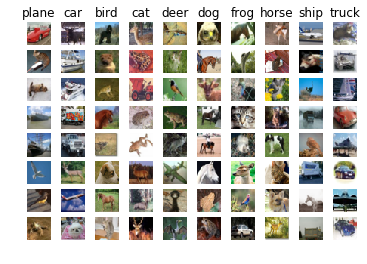

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
- Sky or open areas with the object occupying small portion of the image are misclassified as plane: a reasonably misleading description for guessing a plane.
- Misclassified dogs were actually either cats or their look-alikes.
- Similarly, for others, some misclassifications are justifiable. 


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)       

(49000, 170)
(49000, 169)


In [10]:
# Plot the loss function and train / validation accuracies
def _plot(stats,title):
    
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()

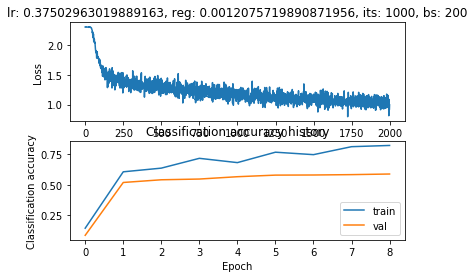

Validation accuracy: 0.587


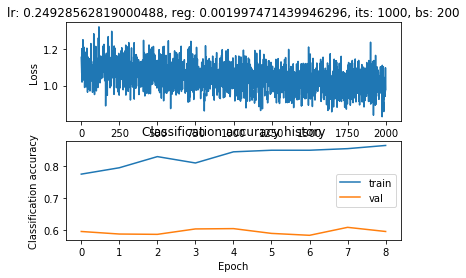

Validation accuracy: 0.609


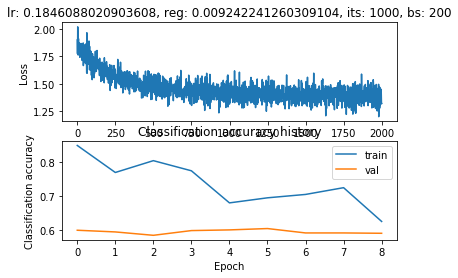

Validation accuracy: 0.588


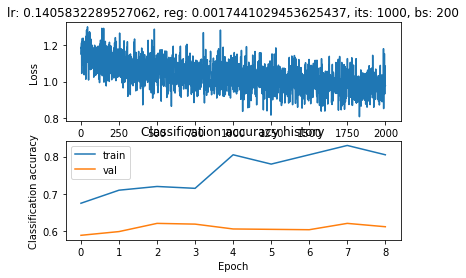

Validation accuracy: 0.609


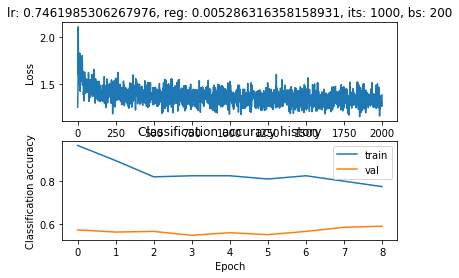

Validation accuracy: 0.58


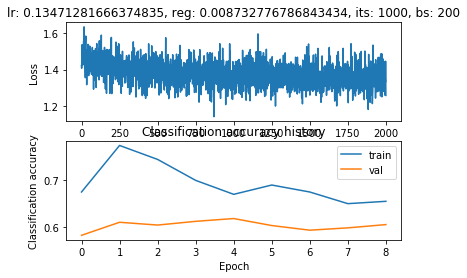

Validation accuracy: 0.61


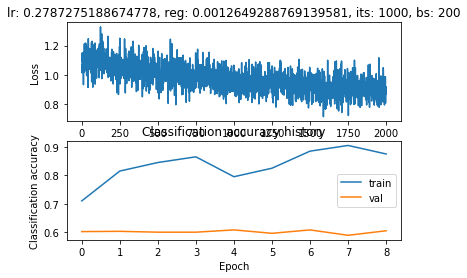

Validation accuracy: 0.625


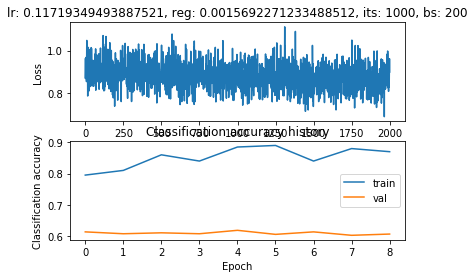

Validation accuracy: 0.613


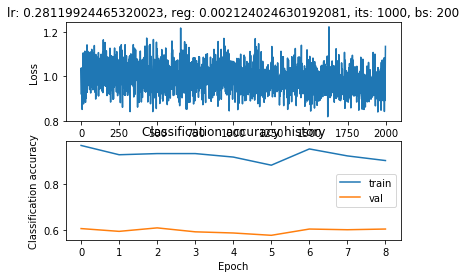

Validation accuracy: 0.598


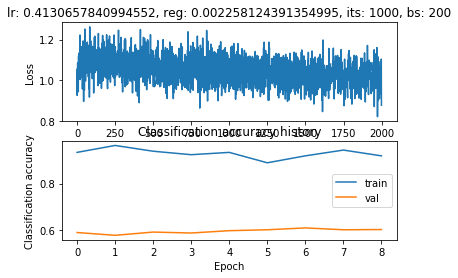

Validation accuracy: 0.607


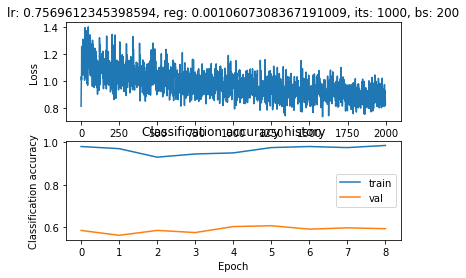

Validation accuracy: 0.61


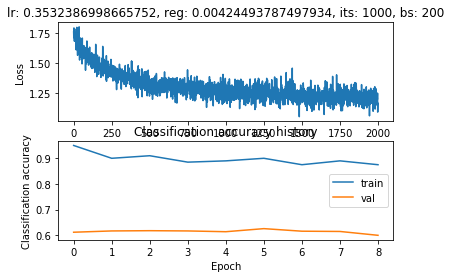

Validation accuracy: 0.618


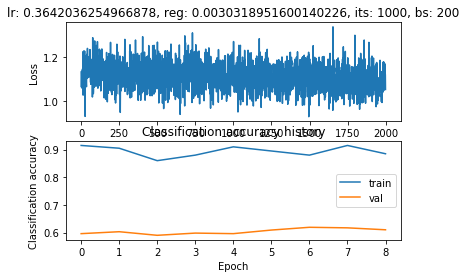

Validation accuracy: 0.617


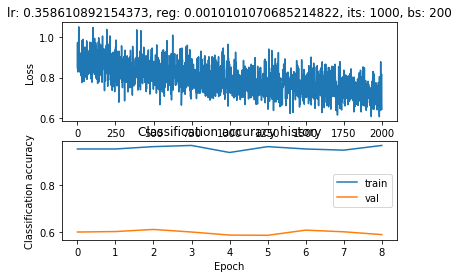

Validation accuracy: 0.602


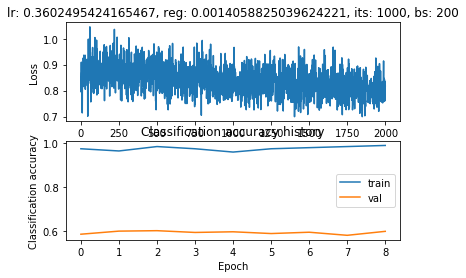

Validation accuracy: 0.611


In [61]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for i in range(15):
    lr = 10**np.random.uniform(-1,0)
    reg = 10**np.random.uniform(-3,-2)
    _stats = net.train(X_train_feats, y_train, X_val_feats, \
                       y_val, num_iters=2000, batch_size=200,\
                           learning_rate=lr, learning_rate_decay=.95,\
                                reg=reg, verbose=False)
    title = 'lr: ' + str(lr) + ', reg: ' + str(reg)
    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    if val_acc > best_val:
        best_net = net
    _plot(_stats, title)
    print('Validation accuracy:', val_acc)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [63]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.606
